# Experiment Tracking with MLFlow (Local)

In this demo we will see how to use MLFlow for tracking experiments, using a toy data set. In the attached lab (below), you will download a larger dataset and attempt to train the best model that you can.

We should first install mlflow, and add it to the requirements.txt file if not done already.

`pip install mlflow` or `python3 -m pip install mlflow`.

You may also need to `pip install setuptools`.

From here, make sure to save this notebook in a specific folder, and ensure you run all command line commands from the same folder.

In [1]:
import mlflow
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_wine
from sklearn.metrics import accuracy_score

After loading the libraries, we can first check the mlflow version you have. And, just for fun, let's look at the mlflow UI by running `mlflow ui`. After this, we should do two things:
- set the tracking uri
- create or set the experiment

Setting the tracking uri tells mlflow where to save the results of our experiments. We will first save these locally in a sqlite instance. In a future lab we will set up mlflow to run in GCP.

If you've already created an experiment previously that you'd like to use, you can tell mlflow by setting the experiment. You can also use `set_experiment` even if the experiment has not yet been created - mlflow will first check if the experiment exists, and if not, it will create it for you. 

In [2]:
mlflow.__version__

'2.15.1'

Running the below code will create a sqlite database and an mlruns folder in the current directory.

In [3]:
mlflow.set_tracking_uri('https://mlflow-server-931658252548.us-west2.run.app')
mlflow.set_experiment('demo-experiment')

2025/04/17 09:55:14 INFO mlflow.tracking.fluent: Experiment with name 'demo-experiment' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/1', creation_time=1744908915227, experiment_id='1', last_update_time=1744908915227, lifecycle_stage='active', name='demo-experiment', tags={}>

From here, we can load the wine data from sklearn and take a look at it. Then let's play around with some models, without using mlflow for now, to get a sense of why mlflow might come in handy.

In [4]:
wine = load_wine()
df_wine = pd.DataFrame(data=wine.data, columns=wine.feature_names)
df_wine.head(3)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0


In [5]:
y = wine.target
X = df_wine
dt = DecisionTreeClassifier(max_depth=4)
dt.fit(X, y)

DecisionTreeClassifier(max_depth=4)

In [6]:
accuracy_score(y, dt.predict(df_wine))

0.9887640449438202

## Train a Model Using MLFLow

In this section, let's train a simple decision tree model, where we will now adjust the maximum depth (`max_depth`) of the tree, and save the results of each run of the experiment using mlflow. To do so, we need to tell mlflow to start recording. We do this with `start_run`. 

The things we might want to record in this simple case are:
- the value of `max_depth`
- the corresponding accuracy of the model

We can also tag each run to make it easier to identify them later.

After running the below code, be sure to check the mlflow UI by running the following in the terminal from the same directory as where you saved this notebook:

`mlflow ui` note that just running this you will not see any of your experiments. You must specify the uri (the place where all of your results are being stored)

`mlflow ui --backend-store-uri sqlite:///mlflow.db`

In [7]:
with mlflow.start_run():
    # log parameters and log metrics
    # parameters: hyperparameters
    # metrics: model performance metrics

    mlflow.set_tags({"Model":"decision-tree", "Train Data": "all-data"})

    tree_depth = 5
    dt = DecisionTreeClassifier(max_depth=tree_depth)
    dt.fit(X, y)
    acc = accuracy_score(y, dt.predict(df_wine))

    mlflow.log_param("max_depth", tree_depth)
    mlflow.log_metric("accuracy", acc)

mlflow.end_run()

2025/04/17 09:55:26 INFO mlflow.tracking._tracking_service.client: 🏃 View run treasured-smelt-960 at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/1/runs/ba30859e62434af5927ee3579126a17f.
2025/04/17 09:55:26 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/1.


Let's do it again, but this time we'll use a random forest, which has some other hyperparameters we can tune, which makes keeping track of things a little more complex without a tool like mlflow.

In [8]:
from sklearn.ensemble import RandomForestClassifier

with mlflow.start_run():
    mlflow.set_tags({"Model":"random-forest", "Train Data": "all-data"})

    ntree = 1000
    mtry = 4

    mlflow.log_params({'n_estimators':ntree, 'max_features':mtry})

    rf = RandomForestClassifier(n_estimators = ntree, max_features = mtry, oob_score = True)
    rf.fit(X,y)
    acc = rf.oob_score_
    #acc = accuracy_score(y, rf.predict(X))
    mlflow.log_metric('accuracy', acc)

mlflow.end_run()

2025/04/17 09:56:21 INFO mlflow.tracking._tracking_service.client: 🏃 View run spiffy-swan-53 at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/1/runs/48dce302695247109191a36830165f67.
2025/04/17 09:56:21 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/1.


Typically, in a real-world scenario, you wouldn't change your parameter values manually and re-run your code, you would either use a loop to loop through different parameter values, or you'd use a built-in method for doing cross-validation, of which there are a few. First, let's use a simple loop to run the experiment multiple times, and save the results of each run.

In [9]:
ntrees = [20,40,60,80,100]
mtrys = [3,4,5]
for i in ntrees:
    for j in mtrys:
        with mlflow.start_run():
            mlflow.set_tags({"Model":"random-forest", "Train Data": "all-data"})

            mlflow.log_params({'n_estimators':i, 'max_features':j})

            rf = RandomForestClassifier(n_estimators = i, max_features = j, oob_score = True)
            rf.fit(X,y)
            acc = rf.oob_score_
            #acc = accuracy_score(y, rf.predict(X))
            mlflow.log_metric('accuracy', acc)
        mlflow.end_run()

2025/04/17 09:56:24 INFO mlflow.tracking._tracking_service.client: 🏃 View run bedecked-panda-645 at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/1/runs/7199e39d7d3b4d2881b2d0b60ada6ffd.
2025/04/17 09:56:24 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/1.
2025/04/17 09:56:24 INFO mlflow.tracking._tracking_service.client: 🏃 View run serious-gnat-969 at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/1/runs/56fd31d5e2e2453e8cff190d8b215b3c.
2025/04/17 09:56:24 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/1.
2025/04/17 09:56:25 INFO mlflow.tracking._tracking_service.client: 🏃 View run luminous-whale-837 at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/1/runs/19173da4dd23485e884504a01b425b26.
2025/04/17 09:56:25 INFO mlflow.tracking._tracking_service.cli

## Training a Model with mlflow and hyperopt

One way of tuning your model is to use the `hyperopt` library. `hyperopt` is a library that does hyperparameter tuning, and does so in a way that makes it easy for mlflow to keep track of the results. 

First, install the libraries you don't have, and then load them below. We do not use `hyperopt` much in the class, so if you don't want to add it to your requirements.txt file, you don't have to.

For this exercise, we'll split the data into training and validation, and then we'll train decision trees and random forests and use `hyperopt` to do the hyperparameter tuning and find the best model for us.

In [10]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

From the above we will use `cross_val_score` for our metric, `fmin` is used by `hyperopt` to do the tuning, `tpe` (Tree of Parzen Estimators) is the algorithm used to search the hyperparameter space,  `hp` has methods we need to use for defining our search space, `STATUS_OK` is a status message that each run completed, and `Trials` keeps track of each run.

In [11]:
def objective(params):
    with mlflow.start_run():
        classifier_type = params['type']
        del params['type']
        if classifier_type == 'dt':
            clf = DecisionTreeClassifier(**params)
        elif classifier_type == 'rf':
            clf = RandomForestClassifier(**params)        
        else:
            return 0
        acc = cross_val_score(clf, X, y).mean()

        mlflow.set_tag("Model", classifier_type)
        mlflow.log_params(params)
        mlflow.log_metric("accuracy", acc)
        mlflow.end_run()
        return {'loss': -acc, 'status': STATUS_OK}

search_space = hp.choice('classifier_type', [
    {
        'type': 'dt',
        'criterion': hp.choice('dtree_criterion', ['gini', 'entropy']),
        'max_depth': hp.choice('dtree_max_depth', [None, hp.randint('dtree_max_depth_int', 1,10)]),
        'min_samples_split': hp.randint('dtree_min_samples_split', 2,10)
    },
    {
        'type': 'rf',
        'n_estimators': hp.randint('rf_n_estimators', 20, 500),
        'max_features': hp.randint('rf_max_features', 2,9),
        'criterion': hp.choice('criterion', ['gini', 'entropy'])
    },
])

algo = tpe.suggest
trials = Trials()

In [12]:
best_result = fmin(
        fn=objective, 
        space=search_space,
        algo=algo,
        max_evals=32,
        trials=trials)

  0%|          | 0/32 [00:00<?, ?trial/s, best loss=?]

2025/04/17 09:57:00 INFO mlflow.tracking._tracking_service.client: 🏃 View run stylish-elk-366 at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/1/runs/de8c704c4d924fdd89007aeb02738186.

2025/04/17 09:57:00 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/1.



  3%|▎         | 1/32 [00:00<00:17,  1.78trial/s, best loss: -0.9103174603174604]

2025/04/17 09:57:01 INFO mlflow.tracking._tracking_service.client: 🏃 View run learned-midge-348 at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/1/runs/863d5661f7a94fc49da8254758b29ab2.

2025/04/17 09:57:01 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/1.



  6%|▋         | 2/32 [00:01<00:16,  1.83trial/s, best loss: -0.9103174603174604]

2025/04/17 09:57:01 INFO mlflow.tracking._tracking_service.client: 🏃 View run enthused-jay-704 at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/1/runs/86b83fada93a4f55a8ace64afd4b5c39.

2025/04/17 09:57:01 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/1.



  9%|▉         | 3/32 [00:01<00:19,  1.49trial/s, best loss: -0.9553968253968254]

2025/04/17 09:57:03 INFO mlflow.tracking._tracking_service.client: 🏃 View run bouncy-loon-185 at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/1/runs/9227717107f64e80b9dbaa613c9267b3.

2025/04/17 09:57:03 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/1.



 12%|█▎        | 4/32 [00:03<00:24,  1.13trial/s, best loss: -0.9720634920634922]

2025/04/17 09:57:04 INFO mlflow.tracking._tracking_service.client: 🏃 View run fortunate-pug-933 at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/1/runs/6666556caf27406facb9f022cd05e643.

2025/04/17 09:57:04 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/1.



 16%|█▌        | 5/32 [00:04<00:29,  1.09s/trial, best loss: -0.9720634920634922]

2025/04/17 09:57:05 INFO mlflow.tracking._tracking_service.client: 🏃 View run orderly-stoat-991 at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/1/runs/1bfb27ffa71c49b78d0d29b4eccd8fa8.

2025/04/17 09:57:05 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/1.



 19%|█▉        | 6/32 [00:05<00:26,  1.02s/trial, best loss: -0.9720634920634922]

2025/04/17 09:57:06 INFO mlflow.tracking._tracking_service.client: 🏃 View run auspicious-snake-154 at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/1/runs/b02fba48a4b548af996cbf7d277e00b7.

2025/04/17 09:57:06 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/1.



 22%|██▏       | 7/32 [00:06<00:27,  1.10s/trial, best loss: -0.9720634920634922]

2025/04/17 09:57:07 INFO mlflow.tracking._tracking_service.client: 🏃 View run unleashed-newt-762 at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/1/runs/6888f93ecefb47c4a9843326de7c2599.

2025/04/17 09:57:07 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/1.



 25%|██▌       | 8/32 [00:07<00:23,  1.02trial/s, best loss: -0.9777777777777779]

2025/04/17 09:57:07 INFO mlflow.tracking._tracking_service.client: 🏃 View run righteous-ant-320 at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/1/runs/3059f2e9c1c84775a96c33d1cb144016.

2025/04/17 09:57:07 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/1.



 28%|██▊       | 9/32 [00:07<00:18,  1.24trial/s, best loss: -0.9777777777777779]

2025/04/17 09:57:08 INFO mlflow.tracking._tracking_service.client: 🏃 View run honorable-shark-55 at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/1/runs/f1458bfdb3df4555ad6435a1e0c8da8c.

2025/04/17 09:57:08 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/1.



 31%|███▏      | 10/32 [00:08<00:15,  1.42trial/s, best loss: -0.9777777777777779]

2025/04/17 09:57:09 INFO mlflow.tracking._tracking_service.client: 🏃 View run melodic-fox-317 at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/1/runs/78223eac298c4ad99b223fbffdc29193.

2025/04/17 09:57:09 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/1.



 34%|███▍      | 11/32 [00:09<00:14,  1.44trial/s, best loss: -0.9777777777777779]

2025/04/17 09:57:10 INFO mlflow.tracking._tracking_service.client: 🏃 View run fun-snake-596 at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/1/runs/1a5ca7ceeede4a6ca4d9f7b17650d5af.

2025/04/17 09:57:10 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/1.



 38%|███▊      | 12/32 [00:10<00:16,  1.22trial/s, best loss: -0.9833333333333332]

2025/04/17 09:57:11 INFO mlflow.tracking._tracking_service.client: 🏃 View run amazing-gnat-119 at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/1/runs/0762e459b01e475b83cadf1ca7776d8f.

2025/04/17 09:57:11 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/1.



 41%|████      | 13/32 [00:11<00:17,  1.11trial/s, best loss: -0.9833333333333332]

2025/04/17 09:57:12 INFO mlflow.tracking._tracking_service.client: 🏃 View run capable-hawk-797 at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/1/runs/32d72bc61eb149e7a06d06ca8d6ed779.

2025/04/17 09:57:12 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/1.



 44%|████▍     | 14/32 [00:12<00:16,  1.07trial/s, best loss: -0.9833333333333332]

2025/04/17 09:57:12 INFO mlflow.tracking._tracking_service.client: 🏃 View run beautiful-boar-274 at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/1/runs/70e6c0e6bb59469989a4d15e49c249ef.

2025/04/17 09:57:12 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/1.



 47%|████▋     | 15/32 [00:13<00:15,  1.08trial/s, best loss: -0.9833333333333332]

2025/04/17 09:57:13 INFO mlflow.tracking._tracking_service.client: 🏃 View run amusing-shrimp-244 at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/1/runs/25cad08e6c314e15a9d53251ea08e927.

2025/04/17 09:57:13 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/1.



 50%|█████     | 16/32 [00:13<00:13,  1.16trial/s, best loss: -0.9833333333333332]

2025/04/17 09:57:15 INFO mlflow.tracking._tracking_service.client: 🏃 View run gentle-panda-632 at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/1/runs/0fa675a173714a1e9a4c228c9a5672ae.

2025/04/17 09:57:15 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/1.



 53%|█████▎    | 17/32 [00:15<00:14,  1.02trial/s, best loss: -0.9833333333333332]

2025/04/17 09:57:15 INFO mlflow.tracking._tracking_service.client: 🏃 View run marvelous-carp-976 at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/1/runs/5b1f35c473504729bff6fe970d01ab28.

2025/04/17 09:57:15 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/1.



 56%|█████▋    | 18/32 [00:16<00:13,  1.04trial/s, best loss: -0.9833333333333332]

2025/04/17 09:57:16 INFO mlflow.tracking._tracking_service.client: 🏃 View run spiffy-seal-285 at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/1/runs/6ca576adecda4ab88d764021ef58e2a5.

2025/04/17 09:57:16 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/1.



 59%|█████▉    | 19/32 [00:16<00:10,  1.24trial/s, best loss: -0.9833333333333332]

2025/04/17 09:57:16 INFO mlflow.tracking._tracking_service.client: 🏃 View run worried-toad-463 at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/1/runs/2be82d62450e456da0cb91a6973848bc.

2025/04/17 09:57:16 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/1.



 62%|██████▎   | 20/32 [00:16<00:08,  1.46trial/s, best loss: -0.9833333333333332]

2025/04/17 09:57:18 INFO mlflow.tracking._tracking_service.client: 🏃 View run brawny-ray-240 at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/1/runs/113ca4f17d724a49b40d699dde45a738.

2025/04/17 09:57:18 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/1.



 66%|██████▌   | 21/32 [00:18<00:10,  1.04trial/s, best loss: -0.9833333333333332]

2025/04/17 09:57:19 INFO mlflow.tracking._tracking_service.client: 🏃 View run thundering-calf-892 at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/1/runs/889214a0bcc54a7ba83a4d381455e7e1.

2025/04/17 09:57:19 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/1.



 69%|██████▉   | 22/32 [00:19<00:08,  1.15trial/s, best loss: -0.9833333333333332]

2025/04/17 09:57:20 INFO mlflow.tracking._tracking_service.client: 🏃 View run agreeable-bass-580 at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/1/runs/75e9962d8a64434a922974a8e8ce1dbd.

2025/04/17 09:57:20 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/1.



 72%|███████▏  | 23/32 [00:20<00:10,  1.13s/trial, best loss: -0.9833333333333332]

2025/04/17 09:57:21 INFO mlflow.tracking._tracking_service.client: 🏃 View run thundering-mink-411 at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/1/runs/1aee3f8a24b74b7f9c405e97444f7cc9.

2025/04/17 09:57:21 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/1.



 75%|███████▌  | 24/32 [00:21<00:08,  1.10s/trial, best loss: -0.9833333333333332]

2025/04/17 09:57:23 INFO mlflow.tracking._tracking_service.client: 🏃 View run lyrical-bass-872 at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/1/runs/d8992dc9790d44b080e151b657d84e65.

2025/04/17 09:57:23 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/1.



 78%|███████▊  | 25/32 [00:23<00:08,  1.23s/trial, best loss: -0.9833333333333332]

2025/04/17 09:57:24 INFO mlflow.tracking._tracking_service.client: 🏃 View run industrious-doe-525 at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/1/runs/4f27d89d9a974e0da0fea61289d88b82.

2025/04/17 09:57:24 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/1.



 81%|████████▏ | 26/32 [00:24<00:07,  1.18s/trial, best loss: -0.9833333333333332]

2025/04/17 09:57:25 INFO mlflow.tracking._tracking_service.client: 🏃 View run nervous-hound-467 at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/1/runs/507c37755f1b45a3b833fb877bcde4e2.

2025/04/17 09:57:25 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/1.



 84%|████████▍ | 27/32 [00:25<00:05,  1.13s/trial, best loss: -0.9833333333333332]

2025/04/17 09:57:26 INFO mlflow.tracking._tracking_service.client: 🏃 View run sassy-hog-65 at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/1/runs/6dfbb99aaa5f4ec589b00822b48a5415.

2025/04/17 09:57:26 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/1.



 88%|████████▊ | 28/32 [00:26<00:04,  1.09s/trial, best loss: -0.9833333333333332]

2025/04/17 09:57:27 INFO mlflow.tracking._tracking_service.client: 🏃 View run agreeable-crane-869 at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/1/runs/ded0b4f5ed554013af8c649118b87c49.

2025/04/17 09:57:27 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/1.



 91%|█████████ | 29/32 [00:27<00:02,  1.01trial/s, best loss: -0.9833333333333332]

2025/04/17 09:57:28 INFO mlflow.tracking._tracking_service.client: 🏃 View run big-ox-255 at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/1/runs/308a57877345415a8259b7ec0b66e7eb.

2025/04/17 09:57:28 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/1.



 94%|█████████▍| 30/32 [00:28<00:01,  1.09trial/s, best loss: -0.9833333333333332]

2025/04/17 09:57:28 INFO mlflow.tracking._tracking_service.client: 🏃 View run receptive-gull-599 at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/1/runs/3c31841d894d48a59c0c57afce989d71.

2025/04/17 09:57:28 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/1.



 97%|█████████▋| 31/32 [00:28<00:00,  1.26trial/s, best loss: -0.9833333333333332]

2025/04/17 09:57:29 INFO mlflow.tracking._tracking_service.client: 🏃 View run thundering-hare-181 at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/1/runs/55dc2902831d4dfc9c6c0397b0874dd3.

2025/04/17 09:57:29 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/1.



100%|██████████| 32/32 [00:29<00:00,  1.07trial/s, best loss: -0.9833333333333332]


In [13]:
best_result

{'classifier_type': 1,
 'criterion': 0,
 'rf_max_features': 2,
 'rf_n_estimators': 350}

### Using Autologging

Rather than manually logging parameters and metrics, mlflow has an autolog feature, which is compatible with a subset of python libraries, such as sklearn. Autologging makes it easy to log all of the important stuff, without having to manually write lines of code to log the parameters. However, sometimes you will want to have finer control over what gets logged, and should instead skip autologging.

In [14]:

with mlflow.start_run():
    mlflow.sklearn.autolog()
    tree_depth = 5
    dt = DecisionTreeClassifier(max_depth=tree_depth)
    dt.fit(X_train, y_train)
    mlflow.sklearn.autolog(disable=True)
mlflow.end_run()

2025/04/17 09:57:40 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/04/17 09:57:41 INFO mlflow.tracking._tracking_service.client: 🏃 View run upset-gull-925 at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/1/runs/567658d1b44a4fe28ea38469d5f48c68.
2025/04/17 09:57:41 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/1.


# Artifact Tracking and Model Registry (Local)

In this section we will save some artifacts from our model as we go through the model development process. There are a few things that might be worth saving, such as datasets, plots, and the final model itself that might go into production later.

## Data

First, let's see how we can store our important datasets, in a compressed format, for use for later, for example, in case we get a new request about our model and need to run some analyses (such as "what is the distribution of this feature, but only for this specific subset of data?" or "how did the model do on these particular observations from your validation set?").

In [15]:
import os 

os.makedirs('save_data', exist_ok = True)

X_train.to_parquet('save_data/x_train.parquet')

mlflow.log_artifact('save_data/x_train.parquet')

In [16]:
X_test.to_parquet('save_data/x_test.parquet')

mlflow.log_artifacts('save_data/')

You can now go to the mlflow UI, click on the latest run, and select the Artifacts tab. You should see something similar to this:
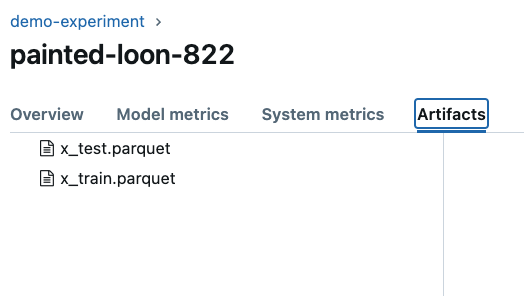

## Images

As part of the model dev process you may end up creating visualizations that can be useful for analysis, or for reporting. You can use mlflow to log the important ones and ignore the rest. After creating the below figure, save into a folder called images, and then you can log whatever is in the `images` folder as an artifact.

array([[<Axes: ylabel='Density'>, <Axes: ylabel='Density'>,
        <Axes: ylabel='Density'>, <Axes: ylabel='Density'>],
       [<Axes: ylabel='Density'>, <Axes: ylabel='Density'>,
        <Axes: ylabel='Density'>, <Axes: ylabel='Density'>],
       [<Axes: ylabel='Density'>, <Axes: ylabel='Density'>,
        <Axes: ylabel='Density'>, <Axes: ylabel='Density'>],
       [<Axes: ylabel='Density'>, <Axes: ylabel='Density'>,
        <Axes: ylabel='Density'>, <Axes: ylabel='Density'>]], dtype=object)

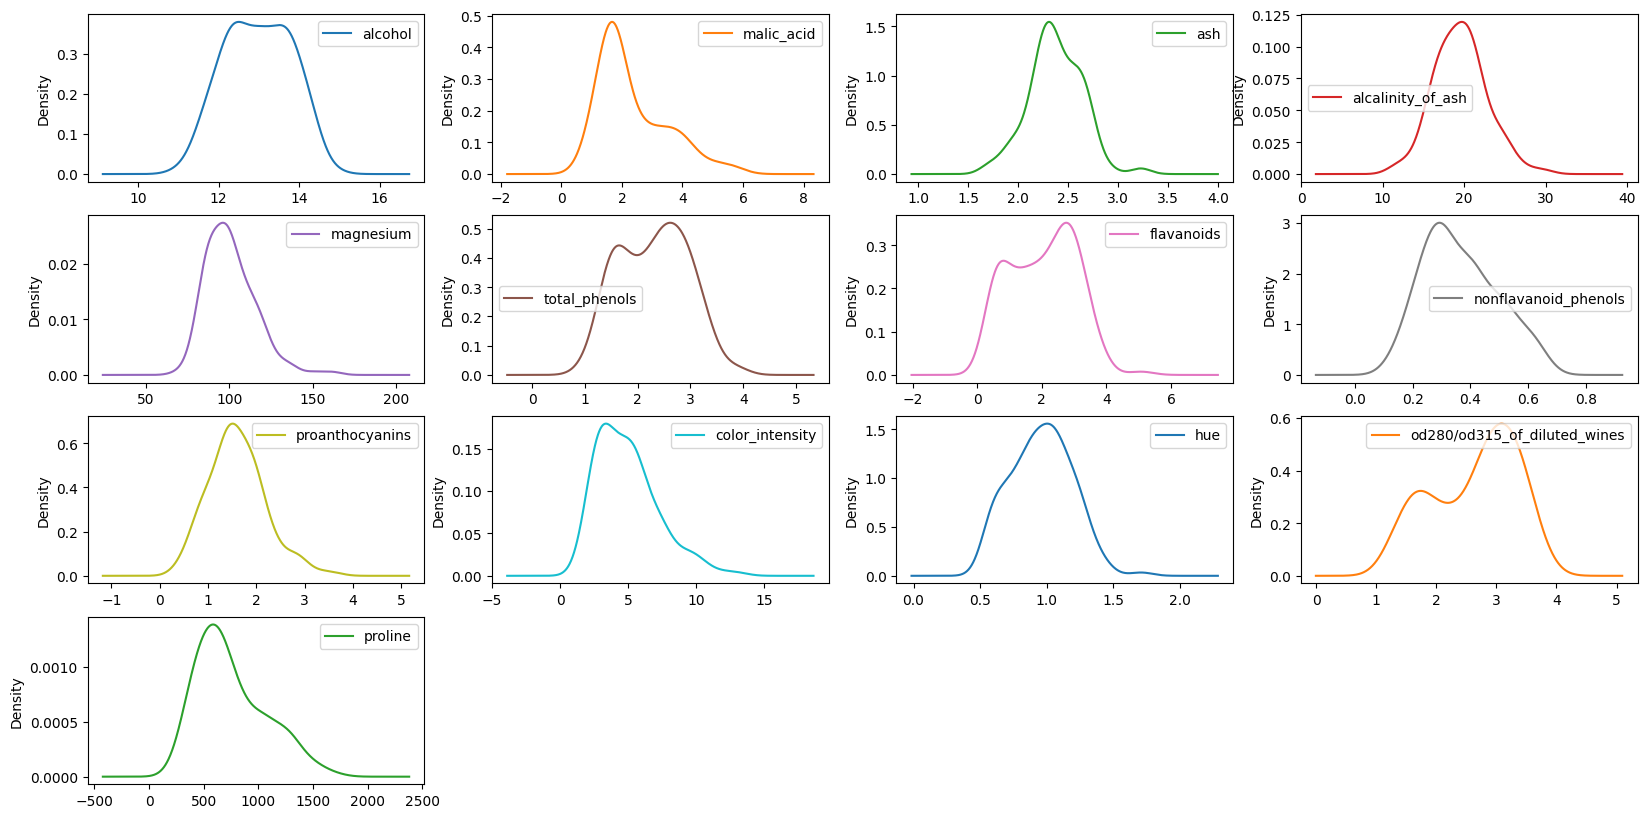

In [17]:
%matplotlib inline
os.makedirs('images', exist_ok = True)
X_train.plot.density(subplots = True, figsize = (20,10), layout = (4,4), sharey = False, sharex = False)

In [18]:
mlflow.log_artifacts('images')
mlflow.end_run()

2025/04/17 09:57:56 INFO mlflow.tracking._tracking_service.client: 🏃 View run nosy-hound-181 at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/1/runs/e3e8d00614754b628df569e08e8095d8.
2025/04/17 09:57:56 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/1.


Notice how all of the artifacts were saved in the same run of the experiment. We could have added an `mlflow.end_run()` in between our `log_artifacts` lines to separate runs if we wanted to.

## Model Management and Model Registry

As you are developing your models you may want to save certain versions of the model, or maybe even all of them, so that you don't have to go back and retrain them later. We can do this in mlflow by logging the models, not as artifacts, but as models, using `log_model`. 

In this section we'll log a couple of models to see how mlflow handles model management. Above, we used `hyperopt` to train a bunch of models at once. Let's do this again, and log some of the models that we train.

### Logging as an Artifact

First we can try logging a model as an artifact. To do this, we must first save the model itself, which we can do by using the `pickle` library. We then log the model as an artifact like we did with data and images. 

In [19]:
import pickle

os.makedirs('../models', exist_ok = True)

dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

with open('../models/model.pkl','wb') as f:
    pickle.dump(dt,f)

# First we'll log the model as an artifact
mlflow.log_artifact('../models/model.pkl', artifact_path='my_models')

### Logging as a Model

Logging the model as an artifact only logs the pickle file (the serialized version of the model). It's not really very useful, especially since models contain so much metadata that might be critical to know for deploying the model later. mlflow has a built-in way of logging models specifically, so let's see how to use this, and how it's different from logging models as an artifact.

In [20]:
# Let's do it again, but this time we will log the model using log_model
mlflow.sklearn.log_model(dt, artifact_path = 'better_models')
mlflow.end_run()

2025/04/17 09:58:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/04/17 09:58:03 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2025/04/17 09:58:03 INFO mlflow.tracking._tracking_service.client: 🏃 View run sedate-squid-642 at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/1/runs/438c896372a0495b958c4d25efc9335d.
2025/04/17 09:58:03 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/1.


Ok, so if you go to the mlflow UI at this point you can see the difference in `log_artifact`, which simply logs the pickle file, and `log_model`, which also gives you information about the environment, required packages, and model flavor.

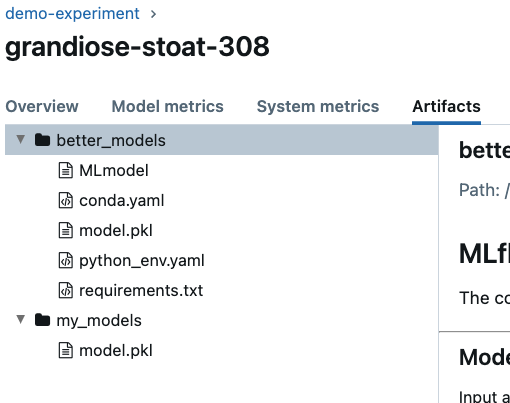

Let's do this one more time, but this time let's use `hyperopt` and log all of the trained models separately. Let's do this in a new experiment called 'demo-experiment2'. 

In [21]:
mlflow.set_experiment('demo-experiment2')
def objective(params):
    with mlflow.start_run():
        classifier_type = params['type']
        del params['type']
        if classifier_type == 'dt':
            clf = DecisionTreeClassifier(**params)
        elif classifier_type == 'rf':
            clf = RandomForestClassifier(**params)        
        else:
            return 0
        acc = cross_val_score(clf, X, y).mean()

        mlflow.set_tag("Model", classifier_type)
        mlflow.log_params(params)
        mlflow.log_metric("accuracy", acc)
        mlflow.sklearn.log_model(clf, artifact_path = 'better_models')
        mlflow.end_run()
        return {'loss': -acc, 'status': STATUS_OK}
search_space = hp.choice('classifier_type', [
    {
        'type': 'dt',
        'criterion': hp.choice('dtree_criterion', ['gini', 'entropy']),
        'max_depth': hp.choice('dtree_max_depth', [None, hp.randint('dtree_max_depth_int', 1,10)]),
        'min_samples_split': hp.randint('dtree_min_samples_split', 2,10)
    },
    {
        'type': 'rf',
        'n_estimators': hp.randint('rf_n_estimators', 20, 500),
        'max_features': hp.randint('rf_max_features', 2,9),
        'criterion': hp.choice('criterion', ['gini', 'entropy'])
    },
])

algo = tpe.suggest
trials = Trials()
best_result = fmin(
        fn=objective, 
        space=search_space,
        algo=algo,
        max_evals=32,
        trials=trials)

2025/04/17 09:58:13 INFO mlflow.tracking.fluent: Experiment with name 'demo-experiment2' does not exist. Creating a new experiment.


  0%|          | 0/32 [00:00<?, ?trial/s, best loss=?]

2025/04/17 09:58:15 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.

2025/04/17 09:58:17 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/17 09:58:17 INFO mlflow.tracking._tracking_service.client: 🏃 View run handsome-zebra-907 at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/2/runs/13a39bf1eaaf4f44bc74e7f3953fbc64.

2025/04/17 09:58:17 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/2.



  3%|▎         | 1/32 [00:03<01:50,  3.58s/trial, best loss: -0.9607936507936508]

2025/04/17 09:58:18 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.

2025/04/17 09:58:19 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/17 09:58:19 INFO mlflow.tracking._tracking_service.client: 🏃 View run serious-stork-882 at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/2/runs/f462ad3033b34d90ab65c58a3a78ba2d.

2025/04/17 09:58:19 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/2.



  6%|▋         | 2/32 [00:05<01:20,  2.68s/trial, best loss: -0.9607936507936508]

2025/04/17 09:58:20 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.

2025/04/17 09:58:22 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/17 09:58:22 INFO mlflow.tracking._tracking_service.client: 🏃 View run welcoming-loon-410 at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/2/runs/039b4061f7284f11a0ee9ad8949d2123.

2025/04/17 09:58:22 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/2.



  9%|▉         | 3/32 [00:08<01:16,  2.63s/trial, best loss: -0.9607936507936508]

2025/04/17 09:58:23 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.

2025/04/17 09:58:24 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/17 09:58:25 INFO mlflow.tracking._tracking_service.client: 🏃 View run thundering-lark-5 at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/2/runs/b6dbc5bdeade4d378f61eeeb9777b363.

2025/04/17 09:58:25 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/2.



 12%|█▎        | 4/32 [00:11<01:19,  2.85s/trial, best loss: -0.9609523809523809]

2025/04/17 09:58:28 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.

2025/04/17 09:58:29 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/17 09:58:29 INFO mlflow.tracking._tracking_service.client: 🏃 View run agreeable-shrike-94 at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/2/runs/506f07f6314e4289b290d6b632e44ceb.

2025/04/17 09:58:29 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/2.



 16%|█▌        | 5/32 [00:15<01:26,  3.20s/trial, best loss: -0.9665079365079364]

2025/04/17 09:58:30 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.

2025/04/17 09:58:31 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/17 09:58:31 INFO mlflow.tracking._tracking_service.client: 🏃 View run caring-doe-713 at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/2/runs/2dd87bb0187b4ce096204d6086c03256.

2025/04/17 09:58:31 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/2.



 19%|█▉        | 6/32 [00:17<01:12,  2.78s/trial, best loss: -0.9665079365079364]

2025/04/17 09:58:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.

2025/04/17 09:58:34 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/17 09:58:34 INFO mlflow.tracking._tracking_service.client: 🏃 View run bedecked-penguin-704 at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/2/runs/3911726d16384a698e293ad7e22660da.

2025/04/17 09:58:34 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/2.



 22%|██▏       | 7/32 [00:20<01:13,  2.95s/trial, best loss: -0.9665079365079364]

2025/04/17 09:58:36 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.

2025/04/17 09:58:36 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/17 09:58:37 INFO mlflow.tracking._tracking_service.client: 🏃 View run beautiful-sloth-535 at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/2/runs/501a02904fa14bf7b64f373243e26039.

2025/04/17 09:58:37 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/2.



 25%|██▌       | 8/32 [00:23<01:08,  2.85s/trial, best loss: -0.9665079365079364]

2025/04/17 09:58:38 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.

2025/04/17 09:58:40 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/17 09:58:40 INFO mlflow.tracking._tracking_service.client: 🏃 View run resilient-fowl-175 at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/2/runs/ef8fd119294f4b6e97edecb19d59fe8d.

2025/04/17 09:58:40 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/2.



 28%|██▊       | 9/32 [00:27<01:17,  3.36s/trial, best loss: -0.9665079365079364]

2025/04/17 09:58:43 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.

2025/04/17 09:58:45 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/17 09:58:45 INFO mlflow.tracking._tracking_service.client: 🏃 View run overjoyed-jay-731 at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/2/runs/d6e2194a20c849e89c9a6c4c8907ab31.

2025/04/17 09:58:45 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/2.



 31%|███▏      | 10/32 [00:31<01:18,  3.55s/trial, best loss: -0.9665079365079364]

2025/04/17 09:58:47 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.

2025/04/17 09:58:48 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/17 09:58:48 INFO mlflow.tracking._tracking_service.client: 🏃 View run sincere-grouse-396 at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/2/runs/3995aff0fa124020be9bc239845c203b.

2025/04/17 09:58:48 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/2.



 34%|███▍      | 11/32 [00:34<01:13,  3.51s/trial, best loss: -0.9665079365079364]

2025/04/17 09:58:50 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.

2025/04/17 09:58:52 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/17 09:58:52 INFO mlflow.tracking._tracking_service.client: 🏃 View run chill-squid-323 at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/2/runs/6abde29eecdb413299294ca6bc271935.

2025/04/17 09:58:52 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/2.



 38%|███▊      | 12/32 [00:38<01:12,  3.64s/trial, best loss: -0.9665079365079364]

2025/04/17 09:58:55 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.

2025/04/17 09:58:56 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/17 09:58:56 INFO mlflow.tracking._tracking_service.client: 🏃 View run fortunate-swan-207 at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/2/runs/67cc57232cb54b3894d651016e868021.

2025/04/17 09:58:56 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/2.



 41%|████      | 13/32 [00:43<01:12,  3.83s/trial, best loss: -0.9665079365079364]

2025/04/17 09:58:58 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.

2025/04/17 09:58:59 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/17 09:59:00 INFO mlflow.tracking._tracking_service.client: 🏃 View run invincible-deer-297 at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/2/runs/a9dd0ace902e4411be125a75600f5823.

2025/04/17 09:59:00 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/2.



 44%|████▍     | 14/32 [00:46<01:03,  3.54s/trial, best loss: -0.9777777777777779]

2025/04/17 09:59:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.

2025/04/17 09:59:03 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/17 09:59:03 INFO mlflow.tracking._tracking_service.client: 🏃 View run worried-wolf-171 at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/2/runs/e03b0027cdc04647b3e38260cac857a3.

2025/04/17 09:59:03 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/2.



 47%|████▋     | 15/32 [00:49<00:58,  3.42s/trial, best loss: -0.9777777777777779]

2025/04/17 09:59:05 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.

2025/04/17 09:59:06 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/17 09:59:06 INFO mlflow.tracking._tracking_service.client: 🏃 View run languid-eel-962 at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/2/runs/7b4cc56561bb49539ba8458b4580deea.

2025/04/17 09:59:06 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/2.



 50%|█████     | 16/32 [00:52<00:52,  3.31s/trial, best loss: -0.9777777777777779]

2025/04/17 09:59:07 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.

2025/04/17 09:59:08 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/17 09:59:08 INFO mlflow.tracking._tracking_service.client: 🏃 View run peaceful-penguin-723 at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/2/runs/77f69c766af8419c9efd291c6a3928dc.

2025/04/17 09:59:08 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/2.



 53%|█████▎    | 17/32 [00:54<00:43,  2.92s/trial, best loss: -0.9777777777777779]

2025/04/17 09:59:09 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.

2025/04/17 09:59:10 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/17 09:59:10 INFO mlflow.tracking._tracking_service.client: 🏃 View run persistent-sheep-93 at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/2/runs/61babf27682744498f59bcf48feb33c9.

2025/04/17 09:59:10 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/2.



 56%|█████▋    | 18/32 [00:56<00:39,  2.80s/trial, best loss: -0.9777777777777779]

2025/04/17 09:59:12 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.

2025/04/17 09:59:13 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/17 09:59:13 INFO mlflow.tracking._tracking_service.client: 🏃 View run amazing-hen-168 at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/2/runs/781764470c054b00ba3bfc7294e0b64e.

2025/04/17 09:59:13 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/2.



 59%|█████▉    | 19/32 [00:59<00:37,  2.87s/trial, best loss: -0.9777777777777779]

2025/04/17 09:59:15 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.

2025/04/17 09:59:16 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/17 09:59:16 INFO mlflow.tracking._tracking_service.client: 🏃 View run wise-cub-974 at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/2/runs/791a910931bc4597a3031f8ce8aa05e3.

2025/04/17 09:59:16 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/2.



 62%|██████▎   | 20/32 [01:02<00:34,  2.90s/trial, best loss: -0.9777777777777779]

2025/04/17 09:59:19 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.

2025/04/17 09:59:19 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/17 09:59:19 INFO mlflow.tracking._tracking_service.client: 🏃 View run bemused-horse-749 at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/2/runs/397263b8cd1f47228fcacaa24cf81d2c.

2025/04/17 09:59:19 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/2.



 66%|██████▌   | 21/32 [01:05<00:32,  2.94s/trial, best loss: -0.9777777777777779]

2025/04/17 09:59:21 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.

2025/04/17 09:59:22 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/17 09:59:22 INFO mlflow.tracking._tracking_service.client: 🏃 View run sedate-shrew-801 at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/2/runs/c05a9769f97a4539907530fcf3063eec.

2025/04/17 09:59:22 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/2.



 69%|██████▉   | 22/32 [01:08<00:27,  2.78s/trial, best loss: -0.9777777777777779]

2025/04/17 09:59:24 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.

2025/04/17 09:59:25 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/17 09:59:25 INFO mlflow.tracking._tracking_service.client: 🏃 View run traveling-frog-844 at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/2/runs/f769772633af4bfa802abcba02908103.

2025/04/17 09:59:25 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/2.



 72%|███████▏  | 23/32 [01:11<00:26,  2.98s/trial, best loss: -0.9831746031746033]

2025/04/17 09:59:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.

2025/04/17 09:59:28 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/17 09:59:28 INFO mlflow.tracking._tracking_service.client: 🏃 View run spiffy-hen-382 at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/2/runs/df0c41ff0cdf4344954cc5d2023706c1.

2025/04/17 09:59:28 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/2.



 75%|███████▌  | 24/32 [01:14<00:23,  2.96s/trial, best loss: -0.9831746031746033]

2025/04/17 09:59:30 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.

2025/04/17 09:59:31 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/17 09:59:31 INFO mlflow.tracking._tracking_service.client: 🏃 View run unique-koi-107 at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/2/runs/05cebcda81cd477597d2bf4184680dcc.

2025/04/17 09:59:31 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/2.



 78%|███████▊  | 25/32 [01:17<00:20,  2.91s/trial, best loss: -0.9831746031746033]

2025/04/17 09:59:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.

2025/04/17 09:59:34 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/17 09:59:34 INFO mlflow.tracking._tracking_service.client: 🏃 View run polite-wolf-594 at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/2/runs/a324ff0aa7244520be2d6c38ecec9a8d.

2025/04/17 09:59:34 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/2.



 81%|████████▏ | 26/32 [01:20<00:18,  3.09s/trial, best loss: -0.9831746031746033]

2025/04/17 09:59:36 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.

2025/04/17 09:59:37 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/17 09:59:37 INFO mlflow.tracking._tracking_service.client: 🏃 View run powerful-crow-520 at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/2/runs/786b0a3474e64e8f9e7052426a58c1c2.

2025/04/17 09:59:37 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/2.



 84%|████████▍ | 27/32 [01:23<00:14,  2.90s/trial, best loss: -0.9831746031746033]

2025/04/17 09:59:38 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.

2025/04/17 09:59:39 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/17 09:59:39 INFO mlflow.tracking._tracking_service.client: 🏃 View run calm-fly-280 at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/2/runs/a1011dc5e1084dd6bc828b88d8ed3c18.

2025/04/17 09:59:39 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/2.



 88%|████████▊ | 28/32 [01:25<00:10,  2.69s/trial, best loss: -0.9831746031746033]

2025/04/17 09:59:40 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.

2025/04/17 09:59:42 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/17 09:59:42 INFO mlflow.tracking._tracking_service.client: 🏃 View run fortunate-ox-412 at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/2/runs/74677513ede744a3ab54516d74b29a5c.

2025/04/17 09:59:42 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/2.



 91%|█████████ | 29/32 [01:28<00:08,  2.80s/trial, best loss: -0.9831746031746033]

2025/04/17 09:59:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.

2025/04/17 09:59:45 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/17 09:59:45 INFO mlflow.tracking._tracking_service.client: 🏃 View run fortunate-rat-620 at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/2/runs/8bbe9e25fb4443a0b64d987cecf60f1d.

2025/04/17 09:59:45 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/2.



 94%|█████████▍| 30/32 [01:31<00:05,  2.91s/trial, best loss: -0.9888888888888889]

2025/04/17 09:59:47 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.

2025/04/17 09:59:49 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/17 09:59:49 INFO mlflow.tracking._tracking_service.client: 🏃 View run capricious-sheep-537 at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/2/runs/c88928c7dd17489dbf5b5f8bb3faf07e.

2025/04/17 09:59:49 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/2.



 97%|█████████▋| 31/32 [01:35<00:03,  3.13s/trial, best loss: -0.9888888888888889]

2025/04/17 09:59:50 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.

2025/04/17 09:59:51 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/17 09:59:51 INFO mlflow.tracking._tracking_service.client: 🏃 View run capable-robin-296 at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/2/runs/31051fe4a4694c3abe48bb60ab2e8294.

2025/04/17 09:59:51 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/2.



100%|██████████| 32/32 [01:37<00:00,  3.05s/trial, best loss: -0.9888888888888889]


### Loading Models

Now that models have been logged, you can load specific models back into python for predicting and further analysis. There are two main ways to do this. The mlflow UI actually gives you some instructions, with code that you copy and paste.

In [22]:
logged_model = 'runs:/31051fe4a4694c3abe48bb60ab2e8294/better_models' #replace with one of your models

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)
loaded_model

/Users/nk13/tmp/env/mlops/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


mlflow.pyfunc.loaded_model:
  artifact_path: better_models
  flavor: mlflow.sklearn
  run_id: 31051fe4a4694c3abe48bb60ab2e8294

In [23]:
sklearn_model = mlflow.sklearn.load_model(logged_model)
sklearn_model

DecisionTreeClassifier(max_depth=8, min_samples_split=9)

In [24]:
sklearn_model.fit(X_train, y_train)
preds = sklearn_model.predict(X_test)
preds[:5]

array([0, 1, 2, 1, 1])

### Model Registry

Typically, you will **register** your *chosen* model, the model you plan to put into production. But, sometimes, after you've chosen and registered a model, you may need to replace that model with a new version. For example, the model may have gone into production and started to degrade in performance, and so the model needed to be retrained. Or, you go to deploy your model and notice an error or bug, and now have to go back and retrain it.

In this section let's see how we take our logged models and register them in the model registry, which then can get picked up by the production process, or engineer, for deployment. First, I'll demonstrate how this is done within the UI, but then below I'll show how we can use the python API to do the same thing.

In [25]:
runid = '31051fe4a4694c3abe48bb60ab2e8294'
mod_path = f'runs:/{runid}/artifacts/better_models'
mlflow.register_model(model_uri = mod_path, name = 'wine_model_from_nb')

Successfully registered model 'wine_model_from_nb'.
2025/04/17 10:01:20 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: wine_model_from_nb, version 1
Created version '1' of model 'wine_model_from_nb'.


<ModelVersion: aliases=[], creation_timestamp=1744909280720, current_stage='None', description='', last_updated_timestamp=1744909280720, name='wine_model_from_nb', run_id='31051fe4a4694c3abe48bb60ab2e8294', run_link='', source='mlflow-artifacts:/2/31051fe4a4694c3abe48bb60ab2e8294/artifacts/artifacts/better_models', status='READY', status_message='', tags={}, user_id='', version='1'>

## Common Issues

- Nothing is appearing in the MLFlow UI: make sure you start the UI from the directory where your notebook is running.  
- I installed a library, but I'm getting an error loading it: be sure you installed it in the same environment as where your notebook is running.  
- MLFlow doesn't seem to be working at all, I'm just getting errors all over the place: this might be a versioning issue.  
- The UI broke, I can't get back to it: `sudo lsof -i :5000 | awk '{print $2}' | tail -n +2 | xargs kill`



# Experiment Tracking and Model Registry Lab

## Overview

In this lab you will each download a new dataset and attempt to train a good model, and use mlflow to keep track of all of your experiments, log your metrics, artifacts and models, and then register a final set of models for "deployment", though we won't actually deploy them anywhere yet.

## Goal

Your goal is **not** to become a master at MLFlow - this is not a course on learning all of the ins and outs of MLFlow. Instead, your goal is to understand when and why it is important to track your model development process (tracking experiments, artifacts and models) and to get into the habit of doing so, and then learn at least the basics of how MLFlow helps you do this so that you can then compare with other tools that are available.

## Data

You can choose your own dataset to use here. It will be helpful to choose a dataset that is already fairly clean and easy to work with. You can even use a dataset that you've used in a previous course. We will do a lot of labs where we do different things with datasets, so if you can find one that is interesting enough for modeling, it should work for most of the rest of the course. 

There are tons of places where you can find open public datasets. Choose something that interests you, but don't overthink it.

[Kaggle Datasets](https://www.kaggle.com/datasets)  
[HuggingFace Datasets](https://huggingface.co/docs/datasets/index)  
[Dagshub Datasets](https://dagshub.com/datasets/)  
[UCI](https://archive.ics.uci.edu/ml/datasets.php)  
[Open Data on AWS](https://registry.opendata.aws/)  
[Yelp](https://www.yelp.com/dataset)  
[MovieLens](https://grouplens.org/datasets/movielens/)  
And so many more...

## Instructions

Once you have selected a set of data, create a brand new experiment in MLFlow and begin exploring your data. Do some EDA, clean up, and learn about your data. You do not need to begin tracking anything yet, but you can if you want to (e.g. you can log different versions of your data as you clean it up and do any feature engineering). Do not spend a ton of time on this part. Your goal isn't really to build a great model, so don't spend hours on feature engineering and missing data imputation and things like that.

Once your data is clean, begin training models and tracking your experiments. If you intend to use this same dataset for your final project, then start thinking about what your model might look like when you actually deploy it. For example, when you engineer new features, be sure to save the code that does this, as you will need this in the future. If your final model has 1000 complex features, you might have a difficult time deploying it later on. If your final model takes 15 minutes to train, or takes a long time to score a new batch of data, you may want to think about training a less complex model.

Now, when tracking your experiments, at a *minimum*, you should:

1. Try at least 3 different ML algorithms (e.g. linear regression, decision tree, random forest, etc.).
2. Do hyperparameter tuning for **each** algorithm.
3. Do some very basic feature selection, and repeat the above steps with these reduced sets of features.
4. Identify the top 3 best models and note these down for later.
6. Choose the **final** "best" model that you would deploy or use on future data, stage it (in MLFlow), and run it on the test set to get a final measure of performance. Don't forget to log the test set metric.
7. Be sure you logged the exact training, validation, and testing datasets for the 3 best models, as well as hyperparameter values, and the values of your metrics.  
8. Push your code to Github. No need to track the mlruns folder, the images folder, any datasets, or the sqlite database in git.

### Turning It In

In the MLFlow UI, next to the refresh button you should see three vertical dots. Click the dots and then download your experiments as a csv file. Open the csv file in Excel and highlight the rows for your top 3 models from step 4, highlight the run where you applied your best model to the test set, and then save as an excel file. Take a snapshot of the Models page in the MLFLow UI showing the model you staged in step 6 above. Submit the excel file and the snapshot to Canvas.

In [26]:
housing_df = pd.read_csv('AmesHousing.csv')
housing_df.head(3)

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000


In [27]:
missing_vals = housing_df.isnull().sum()
missing_vals = missing_vals[missing_vals > 0].sort_values(ascending=False)
print("Columns with missing values:\n", missing_vals)

Columns with missing values:
 Pool QC           2917
Misc Feature      2824
Alley             2732
Fence             2358
Mas Vnr Type      1775
Fireplace Qu      1422
Lot Frontage       490
Garage Cond        159
Garage Qual        159
Garage Finish      159
Garage Yr Blt      159
Garage Type        157
Bsmt Exposure       83
BsmtFin Type 2      81
Bsmt Cond           80
Bsmt Qual           80
BsmtFin Type 1      80
Mas Vnr Area        23
Bsmt Half Bath       2
Bsmt Full Bath       2
BsmtFin SF 1         1
Garage Cars          1
Garage Area          1
Total Bsmt SF        1
Bsmt Unf SF          1
BsmtFin SF 2         1
Electrical           1
dtype: int64


In [28]:
high_missing_cols = ['Pool QC', 'Misc Feature', 'Alley', 'Fence']
housing_df.drop(columns=high_missing_cols, inplace=True)

In [29]:
# Fill categorical columns with mode
cat_fill_mode = ['Mas Vnr Type', 'Fireplace Qu', 'Garage Type', 'Garage Finish', 'Garage Qual', 'Garage Cond',
                 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2', 'Bsmt Qual', 'Bsmt Cond', 'Electrical']
for col in cat_fill_mode:
    housing_df[col].fillna(housing_df[col].mode()[0], inplace=True)

# Fill numerical columns with median
num_fill_median = ['Mas Vnr Area', 'Lot Frontage', 'Garage Yr Blt',
                   'Bsmt Half Bath', 'Bsmt Full Bath', 'BsmtFin SF 1', 'BsmtFin SF 2',
                   'Bsmt Unf SF', 'Total Bsmt SF', 'Garage Cars', 'Garage Area']
for col in num_fill_median:
    housing_df[col].fillna(housing_df[col].median(), inplace=True)

/var/folders/86/c2gz31wn29b2r_53d_q3g3hc0000gn/T/ipykernel_60414/128909573.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  housing_df[col].fillna(housing_df[col].mode()[0], inplace=True)
/var/folders/86/c2gz31wn29b2r_53d_q3g3hc0000gn/T/ipykernel_60414/128909573.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setti

In [30]:
housing_df.isna().sum().sort_values(ascending=False).head(10)

Order             0
Full Bath         0
Fireplaces        0
Functional        0
TotRms AbvGrd     0
Kitchen Qual      0
Kitchen AbvGr     0
Bedroom AbvGr     0
Half Bath         0
Bsmt Half Bath    0
dtype: int64

In [31]:
housing_df_encoded = pd.get_dummies(housing_df, drop_first=True)

In [32]:
y = housing_df_encoded['SalePrice']
X = housing_df_encoded.drop(columns=['SalePrice'])

In [33]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

In [34]:
import os

os.makedirs('data_cleaned', exist_ok=True)
X_train.to_parquet('data_cleaned/X_train.parquet')
X_test.to_parquet('data_cleaned/X_test.parquet')
y_train.to_frame().to_parquet('data_cleaned/y_train.parquet')
y_test.to_frame().to_parquet('data_cleaned/y_test.parquet')

In [35]:
import mlflow
import mlflow.sklearn

# Set the tracking URI (creates a local sqlite db)
mlflow.set_tracking_uri("https://mlflow-server-931658252548.us-west2.run.app")

# Create or switch to your experiment
mlflow.set_experiment("ames-housing-models")

2025/04/17 10:02:03 INFO mlflow.tracking.fluent: Experiment with name 'ames-housing-models' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/3', creation_time=1744909323515, experiment_id='3', last_update_time=1744909323515, lifecycle_stage='active', name='ames-housing-models', tags={}>

In [36]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

with mlflow.start_run():
    mlflow.set_tag("model", "linear_regression")

    model = LinearRegression()
    model.fit(X_train, y_train)
    
    preds = model.predict(X_test)
    mse = mean_squared_error(y_test, preds)
    r2 = r2_score(y_test, preds)

    mlflow.log_metric("mse", mse)
    mlflow.log_metric("r2", r2)
    
    mlflow.sklearn.log_model(model, "model")

2025/04/17 10:02:10 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/04/17 10:02:12 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2025/04/17 10:02:12 INFO mlflow.tracking._tracking_service.client: 🏃 View run selective-dove-60 at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/3/runs/66e01ab330c74cdeb2de38d847be76f9.
2025/04/17 10:02:12 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/3.


In [37]:
from sklearn.tree import DecisionTreeRegressor

with mlflow.start_run():
    mlflow.set_tag("model", "decision_tree")

    max_depth = 5
    model = DecisionTreeRegressor(max_depth=max_depth)
    model.fit(X_train, y_train)
    
    preds = model.predict(X_test)
    mse = mean_squared_error(y_test, preds)
    r2 = r2_score(y_test, preds)

    mlflow.log_param("max_depth", max_depth)
    mlflow.log_metric("mse", mse)
    mlflow.log_metric("r2", r2)
    
    mlflow.sklearn.log_model(model, "model")

2025/04/17 10:02:28 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/04/17 10:02:29 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2025/04/17 10:02:29 INFO mlflow.tracking._tracking_service.client: 🏃 View run magnificent-hawk-449 at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/3/runs/74b72912e2e54523899f2d451e11c0bc.
2025/04/17 10:02:29 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/3.


In [38]:
from sklearn.ensemble import RandomForestRegressor

with mlflow.start_run():
    mlflow.set_tag("model", "random_forest")

    n_estimators = 100
    max_depth = 10

    model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth)
    model.fit(X_train, y_train)
    
    preds = model.predict(X_test)
    mse = mean_squared_error(y_test, preds)
    r2 = r2_score(y_test, preds)

    mlflow.log_params({
        "n_estimators": n_estimators,
        "max_depth": max_depth
    })
    mlflow.log_metric("mse", mse)
    mlflow.log_metric("r2", r2)
    
    mlflow.sklearn.log_model(model, "model")

2025/04/17 10:02:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/04/17 10:02:44 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2025/04/17 10:02:44 INFO mlflow.tracking._tracking_service.client: 🏃 View run abrasive-conch-520 at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/3/runs/f3eb1e47bbe349aba539153500588876.
2025/04/17 10:02:44 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/3.


In [39]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score

def objective(params):
    with mlflow.start_run():
        model_type = params['type']
        del params['type']

        # Convert float params to int where necessary
        if model_type == 'dt':
            params['min_samples_split'] = int(params['min_samples_split'])
            model = DecisionTreeRegressor(**params)
        elif model_type == 'rf':
            params['n_estimators'] = int(params['n_estimators'])
            model = RandomForestRegressor(**params)
        else:
            return {'status': STATUS_FAIL}

        score = cross_val_score(model, X_train, y_train, cv=5, scoring='r2').mean()

        mlflow.set_tag("model_type", model_type)
        mlflow.log_params(params)
        mlflow.log_metric("cv_r2", score)
        mlflow.sklearn.log_model(model, "model")

        return {'loss': -score, 'status': STATUS_OK}



In [41]:
search_space = hp.choice('model_type', [
    {
        'type': 'dt',
        'max_depth': hp.choice('max_depth', list(range(2, 21))),
        'min_samples_split': hp.quniform('min_samples_split', 2, 20, 1)
    },
    {
        'type': 'rf',
        'n_estimators': hp.quniform('n_estimators', 50, 300, 10),
        'max_depth': hp.choice('max_depth_rf', list(range(5, 21))),
        'max_features': hp.uniform('max_features', 0.3, 1.0)
    }
])


In [42]:
trials = Trials()

best = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=30,
    trials=trials
)
print("Best hyperparameters:", best)

  0%|          | 0/30 [00:00<?, ?trial/s, best loss=?]

2025/04/17 10:03:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.

2025/04/17 10:03:03 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/17 10:03:03 INFO mlflow.tracking._tracking_service.client: 🏃 View run handsome-gnat-70 at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/3/runs/4662119828434c309e23958b29c30a5e.

2025/04/17 10:03:03 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/3.



  3%|▎         | 1/30 [00:02<01:21,  2.82s/trial, best loss: -0.6352153986024369]

2025/04/17 10:03:04 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.

2025/04/17 10:03:05 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/17 10:03:05 INFO mlflow.tracking._tracking_service.client: 🏃 View run legendary-auk-388 at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/3/runs/be77b8d4f1bb41c1ad8675569b906650.

2025/04/17 10:03:05 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/3.



  7%|▋         | 2/30 [00:04<01:06,  2.37s/trial, best loss: -0.792783975657722] 

2025/04/17 10:03:06 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.

2025/04/17 10:03:08 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/17 10:03:08 INFO mlflow.tracking._tracking_service.client: 🏃 View run resilient-tern-401 at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/3/runs/a6618dc39d3d4792bfd185fd0c30f39a.

2025/04/17 10:03:08 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/3.



 10%|█         | 3/30 [00:07<01:07,  2.51s/trial, best loss: -0.792783975657722]

2025/04/17 10:03:14 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.

2025/04/17 10:03:16 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/17 10:03:16 INFO mlflow.tracking._tracking_service.client: 🏃 View run industrious-kite-980 at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/3/runs/7be78dcfad414a3586f806d96118518b.

2025/04/17 10:03:16 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/3.



 13%|█▎        | 4/30 [00:16<02:09,  4.99s/trial, best loss: -0.9021148006795217]

2025/04/17 10:03:29 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.

2025/04/17 10:03:30 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/17 10:03:30 INFO mlflow.tracking._tracking_service.client: 🏃 View run beautiful-shrike-231 at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/3/runs/3648ca8c47ff46049bb4aa7a960100bf.

2025/04/17 10:03:30 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/3.



 17%|█▋        | 5/30 [00:29<03:19,  7.98s/trial, best loss: -0.9042425168846234]

2025/04/17 10:03:41 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.

2025/04/17 10:03:41 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/17 10:03:41 INFO mlflow.tracking._tracking_service.client: 🏃 View run thundering-hare-936 at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/3/runs/32bd8565bd5e49f18d4e7014b92d35ff.

2025/04/17 10:03:41 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/3.



 20%|██        | 6/30 [00:41<03:41,  9.21s/trial, best loss: -0.9042425168846234]

2025/04/17 10:04:07 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.

2025/04/17 10:04:08 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/17 10:04:08 INFO mlflow.tracking._tracking_service.client: 🏃 View run gentle-toad-975 at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/3/runs/4a414e20612149d5940b61a3592c558d.

2025/04/17 10:04:08 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/3.



 23%|██▎       | 7/30 [01:08<05:48, 15.17s/trial, best loss: -0.9042425168846234]

2025/04/17 10:04:10 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.

2025/04/17 10:04:11 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/17 10:04:11 INFO mlflow.tracking._tracking_service.client: 🏃 View run sincere-squid-29 at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/3/runs/84dec1aa1b2a40288a1f02015a43680a.

2025/04/17 10:04:11 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/3.



 27%|██▋       | 8/30 [01:11<04:04, 11.12s/trial, best loss: -0.9042425168846234]

2025/04/17 10:04:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.

2025/04/17 10:04:14 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/17 10:04:14 INFO mlflow.tracking._tracking_service.client: 🏃 View run gregarious-deer-813 at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/3/runs/ee891cadd7bf4857aea4e6cfe55368a2.

2025/04/17 10:04:14 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/3.



 30%|███       | 9/30 [01:14<03:00,  8.60s/trial, best loss: -0.9042425168846234]

2025/04/17 10:04:17 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.

2025/04/17 10:04:18 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/17 10:04:18 INFO mlflow.tracking._tracking_service.client: 🏃 View run intrigued-crane-226 at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/3/runs/fd236eb51f744e40a097b3ba04e3eebc.

2025/04/17 10:04:18 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/3.



 33%|███▎      | 10/30 [01:17<02:20,  7.04s/trial, best loss: -0.9042425168846234]

2025/04/17 10:04:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.

2025/04/17 10:04:29 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/17 10:04:29 INFO mlflow.tracking._tracking_service.client: 🏃 View run secretive-shrew-584 at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/3/runs/264c857c4e244277872695b3024c64db.

2025/04/17 10:04:29 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/3.



 37%|███▋      | 11/30 [01:29<02:40,  8.47s/trial, best loss: -0.9042425168846234]

2025/04/17 10:04:32 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.

2025/04/17 10:04:33 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/17 10:04:33 INFO mlflow.tracking._tracking_service.client: 🏃 View run mercurial-koi-566 at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/3/runs/27a00ec8ed1e4b79ba473dc69b066d1a.

2025/04/17 10:04:33 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/3.



 40%|████      | 12/30 [01:32<02:03,  6.87s/trial, best loss: -0.9042425168846234]

2025/04/17 10:04:52 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.

2025/04/17 10:04:54 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/17 10:04:54 INFO mlflow.tracking._tracking_service.client: 🏃 View run zealous-auk-154 at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/3/runs/1aaaf74694b74fd7b03871f4e5f229bd.

2025/04/17 10:04:54 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/3.



 43%|████▎     | 13/30 [01:54<03:14, 11.41s/trial, best loss: -0.9042425168846234]

2025/04/17 10:05:09 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.

2025/04/17 10:05:09 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/17 10:05:10 INFO mlflow.tracking._tracking_service.client: 🏃 View run valuable-skunk-121 at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/3/runs/94baa3ee32984de0a16ae706abfb3554.

2025/04/17 10:05:10 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/3.



 47%|████▋     | 14/30 [02:09<03:19, 12.45s/trial, best loss: -0.9042425168846234]

2025/04/17 10:05:18 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.

2025/04/17 10:05:19 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/17 10:05:19 INFO mlflow.tracking._tracking_service.client: 🏃 View run silent-wren-764 at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/3/runs/5c501429ea44475a89c4d704660ab09f.

2025/04/17 10:05:19 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/3.



 50%|█████     | 15/30 [02:18<02:53, 11.59s/trial, best loss: -0.9042425168846234]

2025/04/17 10:05:23 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.

2025/04/17 10:05:24 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/17 10:05:24 INFO mlflow.tracking._tracking_service.client: 🏃 View run carefree-kite-51 at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/3/runs/81c37a022d73421b80337316e80e229f.

2025/04/17 10:05:24 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/3.



 53%|█████▎    | 16/30 [02:24<02:15,  9.67s/trial, best loss: -0.9042425168846234]

2025/04/17 10:05:26 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.

2025/04/17 10:05:27 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/17 10:05:27 INFO mlflow.tracking._tracking_service.client: 🏃 View run victorious-hare-387 at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/3/runs/ea918dd8e2614d989575b838ce10abf3.

2025/04/17 10:05:27 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/3.



 57%|█████▋    | 17/30 [02:26<01:38,  7.55s/trial, best loss: -0.9042425168846234]

2025/04/17 10:05:29 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.

2025/04/17 10:05:31 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/17 10:05:31 INFO mlflow.tracking._tracking_service.client: 🏃 View run blushing-turtle-93 at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/3/runs/720a4d836bb0487ea4a2e945892159aa.

2025/04/17 10:05:31 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/3.



 60%|██████    | 18/30 [02:31<01:19,  6.59s/trial, best loss: -0.9042425168846234]

2025/04/17 10:05:37 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.

2025/04/17 10:05:39 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/17 10:05:40 INFO mlflow.tracking._tracking_service.client: 🏃 View run grandiose-flea-231 at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/3/runs/ecabaf3188654719ab08e117d2e32b4f.

2025/04/17 10:05:40 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/3.



 63%|██████▎   | 19/30 [02:39<01:18,  7.13s/trial, best loss: -0.9042425168846234]

2025/04/17 10:05:42 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.

2025/04/17 10:05:44 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/17 10:05:44 INFO mlflow.tracking._tracking_service.client: 🏃 View run thundering-pug-584 at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/3/runs/294f0a18de754c84b0c70eb95fdf307a.

2025/04/17 10:05:44 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/3.



 67%|██████▋   | 20/30 [02:43<01:03,  6.32s/trial, best loss: -0.9042425168846234]

2025/04/17 10:05:57 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.

2025/04/17 10:05:59 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/17 10:05:59 INFO mlflow.tracking._tracking_service.client: 🏃 View run upbeat-flea-403 at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/3/runs/908b285ca2694e8bbd80e7cc2022467b.

2025/04/17 10:05:59 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/3.



 70%|███████   | 21/30 [02:59<01:20,  8.95s/trial, best loss: -0.9042425168846234]

2025/04/17 10:06:14 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.

2025/04/17 10:06:16 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/17 10:06:16 INFO mlflow.tracking._tracking_service.client: 🏃 View run shivering-sponge-704 at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/3/runs/36e98ca61617405684a53bc487ec46bd.

2025/04/17 10:06:16 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/3.



 73%|███████▎  | 22/30 [03:15<01:30, 11.29s/trial, best loss: -0.9042425168846234]

2025/04/17 10:06:24 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.

2025/04/17 10:06:25 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/17 10:06:25 INFO mlflow.tracking._tracking_service.client: 🏃 View run learned-cat-963 at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/3/runs/435138896a4c40dea187b200e8a21d0c.

2025/04/17 10:06:25 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/3.



 77%|███████▋  | 23/30 [03:25<01:15, 10.76s/trial, best loss: -0.9042425168846234]

2025/04/17 10:06:42 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.

2025/04/17 10:06:43 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/17 10:06:43 INFO mlflow.tracking._tracking_service.client: 🏃 View run lyrical-koi-811 at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/3/runs/962e0bf45c054fb6a6bc631985f88ae3.

2025/04/17 10:06:43 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/3.



 80%|████████  | 24/30 [03:42<01:16, 12.68s/trial, best loss: -0.9042425168846234]

2025/04/17 10:06:49 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.

2025/04/17 10:06:50 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/17 10:06:50 INFO mlflow.tracking._tracking_service.client: 🏃 View run selective-fowl-94 at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/3/runs/dbdf512591eb4fa5b01a585f062bddba.

2025/04/17 10:06:50 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/3.



 83%|████████▎ | 25/30 [03:50<00:55, 11.18s/trial, best loss: -0.9042425168846234]

2025/04/17 10:06:55 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.

2025/04/17 10:06:56 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/17 10:06:56 INFO mlflow.tracking._tracking_service.client: 🏃 View run glamorous-carp-949 at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/3/runs/897a97ae161b473eb5acb710270f36ac.

2025/04/17 10:06:56 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/3.



 87%|████████▋ | 26/30 [03:55<00:37,  9.46s/trial, best loss: -0.9042425168846234]

2025/04/17 10:07:10 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.

2025/04/17 10:07:12 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/17 10:07:12 INFO mlflow.tracking._tracking_service.client: 🏃 View run unruly-cow-297 at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/3/runs/7a5aae22559c4c94b19f95ed5846fbf3.

2025/04/17 10:07:12 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/3.



 90%|█████████ | 27/30 [04:11<00:34, 11.47s/trial, best loss: -0.9042425168846234]

2025/04/17 10:07:18 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.

2025/04/17 10:07:20 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/17 10:07:21 INFO mlflow.tracking._tracking_service.client: 🏃 View run bold-fox-921 at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/3/runs/3fa7676f3e314a42b08f0a2228f8f679.

2025/04/17 10:07:21 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/3.



 93%|█████████▎| 28/30 [04:20<00:21, 10.67s/trial, best loss: -0.9042425168846234]

2025/04/17 10:07:24 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.

2025/04/17 10:07:25 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/17 10:07:25 INFO mlflow.tracking._tracking_service.client: 🏃 View run stylish-crow-948 at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/3/runs/0f3194c551094b888ee4520083415ed8.

2025/04/17 10:07:25 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/3.



 97%|█████████▋| 29/30 [04:25<00:08,  8.89s/trial, best loss: -0.9042425168846234]

2025/04/17 10:07:36 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.

2025/04/17 10:07:37 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/17 10:07:37 INFO mlflow.tracking._tracking_service.client: 🏃 View run sophisticated-slug-0 at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/3/runs/7795ad8416654c29aa391e342a7d7227.

2025/04/17 10:07:37 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/3.



100%|██████████| 30/30 [04:36<00:00,  9.23s/trial, best loss: -0.9042425168846234]
Best hyperparameters: {'max_depth_rf': 15, 'max_features': 0.5187271051824991, 'model_type': 1, 'n_estimators': 210.0}


In [43]:
# Output top 3
top_trials = sorted(trials.trials, key=lambda x: x['result']['loss'])[:3]
for i, trial in enumerate(top_trials):
    print(f"Trial {i+1}:")
    print(f"  Parameters: {trial['misc']['vals']}")
    print(f"  Loss (negative R2): {trial['result']['loss']}")
    print(f"  Status: {trial['result']['status']}")
    print()

Trial 1:
  Parameters: {'max_depth': [], 'max_depth_rf': [15], 'max_features': [0.5187271051824991], 'min_samples_split': [], 'model_type': [1], 'n_estimators': [210.0]}
  Loss (negative R2): -0.9042425168846234
  Status: ok

Trial 2:
  Parameters: {'max_depth': [], 'max_depth_rf': [11], 'max_features': [0.42220165173258917], 'min_samples_split': [], 'model_type': [1], 'n_estimators': [230.0]}
  Loss (negative R2): -0.9035098244506085
  Status: ok

Trial 3:
  Parameters: {'max_depth': [], 'max_depth_rf': [11], 'max_features': [0.549418197179458], 'min_samples_split': [], 'model_type': [1], 'n_estimators': [280.0]}
  Loss (negative R2): -0.903442805476236
  Status: ok



In [44]:
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np

# Fit model on full train set
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Get feature importances
importances = pd.Series(rf.feature_importances_, index=X_train.columns)
top_features = importances.sort_values(ascending=False).head(30).index.tolist()

print("Top 30 features:")
print(top_features)

Top 30 features:
['Overall Qual', 'Gr Liv Area', 'Total Bsmt SF', '1st Flr SF', 'BsmtFin SF 1', '2nd Flr SF', 'Lot Area', 'Year Built', 'Garage Area', 'Garage Cars', 'Full Bath', 'Year Remod/Add', 'PID', 'Lot Frontage', 'Open Porch SF', 'Bsmt Unf SF', 'Mo Sold', 'Garage Yr Blt', 'Overall Cond', 'Mas Vnr Area', 'Wood Deck SF', 'Order', 'MS Zoning_RM', 'Fireplaces', 'Bsmt Full Bath', 'Garage Finish_Unf', 'TotRms AbvGrd', 'Central Air_Y', 'Kitchen Qual_TA', 'Screen Porch']


In [45]:
X_train_reduced = X_train[top_features]
X_test_reduced = X_test[top_features]

In [48]:
# Trial 1:
#   Parameters: {'max_depth': [], 'max_depth_rf': [15], 'max_features': [0.5187271051824991], 'min_samples_split': [], 'model_type': [1], 'n_estimators': [210.0]}
#   Loss (negative R2): -0.9042425168846234
#   Status: ok

# Trial 2:
#   Parameters: {'max_depth': [], 'max_depth_rf': [11], 'max_features': [0.42220165173258917], 'min_samples_split': [], 'model_type': [1], 'n_estimators': [230.0]}
#   Loss (negative R2): -0.9035098244506085
#   Status: ok

# Trial 3:
#   Parameters: {'max_depth': [], 'max_depth_rf': [11], 'max_features': [0.549418197179458], 'min_samples_split': [], 'model_type': [1], 'n_estimators': [280.0]}
#   Loss (negative R2): -0.903442805476236
#   Status: ok

# Top Hyperopt models
top_models = [
    {'n_estimators': 210, 'max_depth': 15, 'max_features': 0.51873},
    {'n_estimators': 230, 'max_depth': 11, 'max_features': 0.42220},
    {'n_estimators': 280, 'max_depth': 11, 'max_features': 0.54942}
]

In [50]:
# Upload limit 32 MiB
# Set environment variables to enable chunked uploads

import os

# Turn on chunked (“proxy multipart”) uploads  
os.environ["MLFLOW_ENABLE_PROXY_MULTIPART_UPLOAD"]      = "True"  
# Send at most 10 MB per HTTP request  
os.environ["MLFLOW_MULTIPART_UPLOAD_CHUNK_SIZE"]         = str(10 * 1024 * 1024)  
# Switch to chunked mode for any file ≥ 5 MB  
os.environ["MLFLOW_MULTIPART_UPLOAD_MINIMUM_FILE_SIZE"]  = str(5 * 1024 * 1024)

In [51]:
from sklearn.metrics import mean_squared_error, r2_score

for idx, params in enumerate(top_models, 1):
    with mlflow.start_run(run_name=f"Top_Model_{idx}"):
        mlflow.set_tag("model_type", "random_forest_top")
        mlflow.log_params(params)

        model = RandomForestRegressor(
            n_estimators=params['n_estimators'],
            max_depth=params['max_depth'],
            max_features=params['max_features'],
            random_state=42
        )
        model.fit(X_train_reduced, y_train)

        preds = model.predict(X_test_reduced)
        mse = mean_squared_error(y_test, preds)
        r2 = r2_score(y_test, preds)

        mlflow.log_metric("test_mse", mse)
        mlflow.log_metric("test_r2", r2)

        # Save model
        mlflow.sklearn.log_model(model, "model")

        # Save final data used
        X_train_reduced.to_parquet("data_cleaned/X_train_reduced.parquet")
        X_test_reduced.to_parquet("data_cleaned/X_test_reduced.parquet")
        mlflow.log_artifacts("data_cleaned/")


2025/04/17 10:26:30 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/04/17 10:27:01 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2025/04/17 10:27:04 INFO mlflow.tracking._tracking_service.client: 🏃 View run Top_Model_1 at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/3/runs/b9f54dc22be544c3b7aadcc00528de99.
2025/04/17 10:27:04 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-931658252548.us-west2.run.app/#/experiments/3.
2025/04/17 10:27:07 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/04/17 10:27:33 WARNING mlflow.models.model: Input example should be provided to infer model signature if the mod

In [52]:
import mlflow

runs = mlflow.search_runs(experiment_names=["ames-housing-models"])
best_run_id = runs.sort_values("metrics.test_r2", ascending=False).iloc[0]["run_id"]
print("Best Run ID:", best_run_id)

Best Run ID: b9f54dc22be544c3b7aadcc00528de99


In [53]:
model_uri = f"runs:/{best_run_id}/model"
mlflow.register_model(model_uri, "ames_housing_final_model")

Successfully registered model 'ames_housing_final_model'.
2025/04/17 10:28:20 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: ames_housing_final_model, version 1
Created version '1' of model 'ames_housing_final_model'.


<ModelVersion: aliases=[], creation_timestamp=1744910900276, current_stage='None', description='', last_updated_timestamp=1744910900276, name='ames_housing_final_model', run_id='b9f54dc22be544c3b7aadcc00528de99', run_link='', source='mlflow-artifacts:/3/b9f54dc22be544c3b7aadcc00528de99/artifacts/model', status='READY', status_message='', tags={}, user_id='', version='1'>